# Các thư viện cần thiết:

In [1]:
import re
import math
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz, process
from selenium import webdriver
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.action_chains import ActionChains

# Khởi tạo Selenium:

In [2]:
# Đường dẫn đến ChromeDriver
driver_path = r'.\\chromedriver-win64\\chromedriver.exe'

# Đường dẫn đến tệp thực thi của Google Chrome
chrome_path = r'C:\\Program Files\\Google\\Chrome\\Application\\chrome.exe'

# Cấu hình tùy chọn Chrome
options = webdriver.ChromeOptions()
options.binary_location = chrome_path

# Tạo đối tượng Service để chỉ định đường dẫn ChromeDriver
service = Service(driver_path)

# Khởi tạo ChromeDriver với Service và các tùy chọn
driver = webdriver.Chrome(service=service, options=options)

# Thời gian chờ tối đa cho một trang web được hiển thị hoàn chỉnh
wait = WebDriverWait(driver, 2)

# Tạo dataframe để lưu các việc làm thu thập được

In [3]:
# Khởi tạo DataFrame trống với các cột
columns = ['Trang thu thập', 'Tên công ty', 'Tên công việc', 'Vị trí ứng tuyển', 'Yêu cầu bằng cấp', 'Yêu cầu kinh nghiệm',
           'Địa điểm', 'Ngày đăng tuyển', 'Lương tối thiểu', 'Lương tối đa', 'Lương TB']
df = pd.DataFrame(columns=columns)

# Thiết lập kiểu dữ liệu phù hợp
df['Ngày đăng tuyển'] = pd.to_datetime(df['Ngày đăng tuyển'], errors='coerce')
df['Lương tối thiểu'] = pd.to_numeric(df['Lương tối thiểu'], errors='coerce')
df['Lương tối đa'] = pd.to_numeric(df['Lương tối đa'], errors='coerce')
df['Lương TB'] = pd.to_numeric(df['Lương TB'], errors='coerce')

# Lọc các thông tin thu thập

## Tên công việc

In [4]:
# Từ điển từ khóa ánh xạ tên công việc
job_keywords = {
    'Lập trình viên': ['lập trình', 'developer', 'programmer', 'coder', 'software developer', 'engineer', 'dev', 
                       'backend developer', 'frontend developer', 'fullstack developer', 'software coder', 'software engineer', 
                       'python developer', 'java developer', 'c++ developer', 'mobile developer', 'golang developer', 'backend dev', 
                       'frontend dev', 'devops engineer', 'web programmer'],
    
    'Kinh doanh': ['sales', 'marketing', 'media', 'quảng cáo', 'kinh doanh', 'business', 'advertising', 'thương hiệu', 
                   'brand manager', 'digital marketing', 'sales executive', 'account manager', 'bán hàng', 'business development', 
                   'salesman', 'trưởng phòng kinh doanh', 'quản lý bán hàng', 'trade marketing', 'PR', 'quan hệ công chúng'],
    
    'Quản trị viên hệ thống': ['administrator', 'system admin', 'sysadmin', 'quản trị', 'backend', 'system manager', 'quản lí hệ thống',
                               'system engineer', 'infrastructure engineer', 'windows admin', 'linux admin', 'system analyst', 
                               'server administrator', 'cloud administrator', 'it administrator'],
    
    'Nhà phát triển web': ['web developer', 'phát triển web', 'thiết kế web', 'frontend', 'fullstack', 'web designer', 
                           'frontend engineer', 'fullstack engineer', 'wordpress developer', 'html developer', 'css developer', 
                           'javascript developer', 'web engineer', 'ui developer', 'web programmer', 'front-end', 'back-end', 
                           'react developer', 'angular developer'],
    
    'Nhà thiết kế đồ họa': ['graphic designer', 'thiết kế đồ họa', 'graphic', 'artist', 'multimedia designer', 'graphics artist', 
                            'visual designer', 'photoshop expert', 'illustrator', 'creative designer', 'branding designer', 
                            'ui artist', 'motion designer', '2d artist', '3d designer', 'digital artist', 'poster designer'],
    
    'Nhà khoa học dữ liệu': ['data scientist', 'khoa học dữ liệu', 'machine learning scientist', 'data researcher', 
                             'ml scientist', 'ai scientist', 'data science specialist', 'deep learning scientist', 
                             'data exploration', 'data analytics scientist'],
    
    'Nhà phân tích dữ liệu': ['data analyst', 'phân tích dữ liệu', 'business analyst', 'analyst', 'data analytics', 
                              'reporting analyst', 'data specialist', 'bi analyst', 'sql analyst', 'excel analyst', 
                              'business intelligence', 'data visualization', 'dashboard specialist', 'power bi developer'],
    
    'Nhà phát triển phần mềm': ['software developer', 'phát triển phần mềm', 'app developer', 'java developer', 'fullstack', 
                                'software architect', 'mobile application developer', 'desktop application developer', 
                                'application engineer', 'software creator', 'api developer', 'software solutions'],
    
    'Nhà thiết kế giao diện người dùng': ['ui designer', 'ux designer', 'giao diện', 'user interface', 'ui/ux', 'ux/ui', 
                                         'user experience', 'interaction designer', 'ui developer', 'ux researcher', 
                                         'product designer', 'ux writer', 'wireframe designer', 'prototype designer'],
    
    'Chuyên viên tư vấn CNTT': ['it consultant', 'tư vấn', 'brse', 'solution consultant', 'giải pháp', 'it advisory', 
                               'technical consultant', 'system consultant', 'it solutions expert', 'business it consultant'],
    
    'Chuyên viên hỗ trợ kỹ thuật': ['technical support', 'hỗ trợ kỹ thuật', 'it support', 'helpdesk', 'nhân viên kỹ thuật', 
                                    'camera', 'bảo hành', 'tech support', 'desktop support', 'it technician', 'support engineer', 
                                    'pc repair', 'network support', 'hardware technician'],
    
    'Chuyên viên bảo mật thông tin': ['information security', 'bảo mật', 'cybersecurity', 'an ninh', 'security engineer', 
                                     'it security', 'network security', 'security analyst', 'pentester', 'security operations', 
                                     'threat analyst', 'malware analyst'],
    
    'Kỹ sư mạng': ['network engineer', 'kỹ sư mạng', 'networking', 'network admin', 'network architect', 'wireless engineer', 
                   'network technician', 'ccna', 'network administrator', 'wan engineer', 'lan specialist', 'network infrastructure'],
    
    'Kỹ sư học máy': ['machine learning engineer', 'kỹ sư học máy', 'ml engineer', 'machine learning dev', 'ai developer', 
                      'ml architect', 'ai specialist', 'machine learning scientist', 'deep learning engineer', 'model developer'],
    
    'Kỹ sư đám mây': ['cloud engineer', 'kỹ sư đám mây', 'cloud architect', 'aws engineer', 'azure engineer', 'gcp engineer', 
                      'cloud admin', 'cloud solutions architect', 'cloud specialist', 'cloud devops'],
    
    'Kỹ sư phần mềm': ['software engineer', 'kỹ sư phần mềm', 'kỹ thuật phần mềm', 'swe', 'application engineer', 
                       'software dev', 'backend engineer', 'frontend engineer', 'software solutions engineer'],
    
    'Kỹ sư blockchain': ['blockchain engineer', 'kỹ sư blockchain', 'blockchain developer', 'smart contract developer', 
                         'crypto engineer', 'dapp developer', 'web3 developer', 'blockchain architect'],
    
    'Kỹ sư cơ sở dữ liệu': ['database engineer', 'cơ sở dữ liệu', 'database admin', 'dba', 'sql engineer', 'mysql admin', 
                            'oracle dba', 'postgresql engineer', 'database architect', 'data warehouse specialist'],
    
    'Kỹ sư trí tuệ nhân tạo': ['ai engineer', 'kỹ sư trí tuệ nhân tạo', 'artificial intelligence', 'ai architect', 
                               'ai developer', 'machine intelligence engineer', 'artificial intelligence scientist'],
    
    'Kỹ sư kiểm thử phần mềm': ['software tester', 'kiểm thử', 'test engineer', 'qa tester', 'quality assurance', 
                                'qa engineer', 'automation tester', 'manual tester', 'test analyst', 'sdet', 'software qa'],

    'Công nghệ thông tin (tổng quát)': ['it', 'công nghệ thông tin', 'cntt', 'information technology', 'it specialist', 
                                       'it technician', 'it officer', 'it expert', 'it solutions', 'it professional'],
}

# Hàm phân loại
def analyze_job_name(job: str):
    job = job.lower().strip()  # Chuyển về chữ thường và loại bỏ khoảng trắng
    for category, keywords in job_keywords.items():
        match = process.extractOne(job, keywords, scorer=fuzz.partial_ratio)
        if match and match[1] > 80:  # Ngưỡng độ tương đồng > 80%
            return category
    return job  # Trường hợp không khớp với bất kỳ công việc nào

## Ngày đăng tuyển

In [5]:
import datetime

def analyze_posted_date(time: str):
    # Làm sạch dữ liệu đầu vào
    time = time.replace('một', '1')
    
    # Kiểm tra xem chuỗi có phải là ngày tháng không (ví dụ: DD/MM/YYYY)
    try:
        # Thử chuyển đổi chuỗi thành datetime nếu định dạng ngày tháng
        time_value = datetime.datetime.strptime(time, "%d/%m/%Y")
        return time_value
    except ValueError:
        pass  # Nếu không thể chuyển đổi, tiếp tục xử lý theo kiểu khác
    
    # Nếu không phải ngày tháng, xử lý theo các đơn vị thời gian (giây, phút, v.v.)
    words = time.split()
    
    # Tìm vị trí của từ bắt đầu bằng số
    for i, word in enumerate(words):
        if word.isdigit():
            break
    if not words:
        return None  # Chuỗi không hợp lệ
    
    time_value = int(words[i])
    time_unit = words[i+1]

    # Lấy thời điểm hiện tại
    now = datetime.datetime.now()

    # Tính toán thời điểm tương ứng
    if time_unit == 'giây':
        result = now - datetime.timedelta(seconds=time_value)
    elif time_unit == 'phút':
        result = now - datetime.timedelta(minutes=time_value)
    elif time_unit == 'giờ':
        result = now - datetime.timedelta(hours=time_value)
    elif time_unit == 'ngày':
        result = now - datetime.timedelta(days=time_value)
    elif time_unit == 'tháng':
        result = now.replace(month=now.month - time_value)
    elif time_unit == 'năm':
        result = now.replace(year=now.year - time_value)
    else:
        return None

    return result

## Lương

In [6]:
def normalize_salary_format(salary: str):
    salary = salary.lower().strip()
    
    # Chuẩn hóa dạng tiền VNĐ
    if '₫/tháng' in salary:
        salary = salary.replace('₫/tháng', '').replace('tr', 'triệu').strip()  # Loại bỏ ₫/tháng và chuẩn hóa 'tr'
        if '-' in salary:
            salary = salary.replace(' ', '')  # Xóa khoảng trắng để giữ định dạng 'X triệu - Y triệu'
        elif 'tới' in salary:
            salary = salary.replace('tới', 'dưới').strip()
        return salary
    
    # Chuẩn hóa dạng tiền USD
    elif '/tháng' in salary and '$' in salary:
        salary = salary.replace('/tháng', '').replace('$', 'usd').strip()  # Loại bỏ '/tháng' và chuẩn hóa '$'
        if '-' in salary:
            salary = salary.replace(' ', '')  # Xóa khoảng trắng để giữ định dạng 'X USD - Y USD'
        elif 'tới' in salary:
            salary = salary.replace('tới', 'dưới').strip()
        return salary
    
    return salary  # Trả về giá trị không thay đổi nếu không khớp định dạng

def analyze_salary(salary: str):
    salary = normalize_salary_format(salary)
    
    # Nếu là "Thương lượng"
    if salary == 'thương lượng':
        return None, None, None  # Thương lượng: cả 3 cột để trống
    
    # Nếu là "Cạnh tranh"
    elif salary == 'cạnh tranh':
        return 0, 0, 0  # Cạnh tranh: cả 3 cột bằng 0
    
    # Xử lý định dạng 'triệu' (VND)
    elif 'triệu' in salary:
        if 'trên' in salary:
            # Định dạng 'Trên X triệu'
            min_salary = int(float(salary.split('trên')[1].strip().replace('triệu', '').strip()) * 1_000_000)
            return min_salary, None, None
        elif '-' in salary:
            # Định dạng 'X triệu - Y triệu'
            min_salary, max_salary = map(
                lambda x: int(float(x.strip().replace('triệu', '').replace(',', '.')) * 1_000_000),
                salary.split('-')
            )
            avg_salary = (min_salary + max_salary) // 2
            return min_salary, max_salary, avg_salary
        elif 'dưới' in salary:
            # Định dạng 'Dưới X triệu'
            max_salary = int(float(salary.split('dưới')[1].strip().replace('triệu', '').strip()) * 1_000_000)
            return None, max_salary, None
        else:
            # Định dạng 'X triệu'
            avg_salary = int(float(salary.replace('triệu', '').replace(',', '.').strip()) * 1_000_000)
            return None, None, avg_salary
        
    # Xử lý định dạng USD
    elif 'usd' in salary:
        if 'trên' in salary:
            # Định dạng 'Trên X USD'
            min_salary = int(math.floor(float(salary.split('trên')[1].strip().replace('usd', '').replace(',', '').strip()) * 25_000 / 1_000_000) * 1_000_000)
            return min_salary, None, None
        elif '-' in salary:
            # Định dạng 'X USD - Y USD'
            min_salary, max_salary = map(
                lambda x: int(math.floor(float(x.strip().replace('usd', '').replace(',', '').strip()) * 25_000 / 1_000_000) * 1_000_000),
                salary.split('-')
            )
            avg_salary = (min_salary + max_salary) // 2
            return min_salary, max_salary, avg_salary
        elif 'dưới' in salary:
            # Định dạng 'Dưới X USD'
            max_salary = int(math.floor(float(salary.split('dưới')[1].strip().replace('usd', '').replace(',', '').strip()) * 25_000 / 1_000_000) * 1_000_000)
            return None, max_salary, None
        else:
            # Định dạng 'X USD'
            avg_salary = int(math.floor(float(salary.replace('usd', '').replace(',', '').strip()) * 25_000 / 1_000_000) * 1_000_000)
            return None, None, avg_salary
    
    return None, None, None  # Nếu không khớp định dạng, để trống

## Yêu cầu bằng cấp

In [7]:
def degree_assessment(degree: str):
    degree = degree.lower().strip()  # Chuyển về chữ thường và loại bỏ khoảng trắng đầu/cuối
    if 'đại học' in degree or 'cao đẳng' in degree or 'cử nhân' in degree:
        return 'Cử nhân'
    elif 'trung học' in degree:
        return 'Trung học'
    elif 'trung cấp' in degree:
        return 'Trung cấp'
    else:
        return degree

## Yêu cầu kinh nghiệm

In [8]:
def level_assessment(level: str):
    level = level.lower().strip()
    # Kiểm tra 'Chưa', 'Không'
    if 'chưa' in level or 'không' in level:
        return 'Fresher'

    # Kiểm tra 'Dưới X năm'
    elif 'dưới' in level:
        return 'Fresher'

    # Kiểm tra 'Trên X năm'
    elif 'trên' in level or 'hơn' in level:
        return 'Senior'

    elif '-' in level:
        # Định dạng 'X - Y năm kinh nghiệm'
        match = re.match(r'(\d+)\s*-\s*(\d+)\s*năm\s*', level)
        x = int(match.group(1))
        y = int(match.group(2))
        avg = (x + y) / 2
        
    else:
        # Định dạng 'X (năm)'
        match = re.match(r'(\d+)\s*(năm)?\s*', level)
        if match:
            avg = int(match.group(1))

    # Đánh giá cấp độ
    if avg <= 1:
        return 'Fresher'
    elif 1 < avg < 3:
        return 'Junior'
    elif 3 <= avg < 5:
        return 'Middle'
    else:
        return 'Senior'

# Truy cập và trích xuất dữ liệu từ trang web

## CareerLink

In [ ]:
careerlink_url = 'https://www.careerlink.vn/viec-lam/cntt-phan-mem/19'
max_pages = 5  # Số trang tối đa muốn lấy (thay đổi tùy ý)

try:
    for page in range(1, max_pages + 1):
        # Mở trang web CareerLink
        url = f'{careerlink_url}?page={page}' if page > 1 else careerlink_url
        driver.get(url)
        
        # Chờ CAPTCHA xuất hiện nếu có
        try:
            captcha_box = wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'g-recaptcha')))
            print("Hãy giải CAPTCHA thủ công trên trình duyệt và nhấn Enter để tiếp tục...")
            input()  # Dừng chương trình để bạn giải CAPTCHA thủ công
        except:
            pass
            
        # Trích xuất các công việc
        jobs = wait.until(EC.presence_of_all_elements_located((By.CLASS_NAME, 'list-group-item')))

        for job in jobs:
            try:
                job_text = job.text.split('\n')  # Tách thông tin thành từng dòng
                if len(job_text) < 5:  # Bỏ qua các mục không hợp lệ
                    continue
                index_save = next((i for i, line in enumerate(job_text) if 'Lưu' in line), None)  # Bỏ các dòng 'Lưu' và trên nó
                if index_save is not None:
                    job_text = job_text[index_save + 1:]

                # Click vào công việc để chuyển đến trang thông tin chi tiết của công việc đó
                job_detail_link = job.find_element(By.CSS_SELECTOR, 'a.job-link.clickable-outside')
                job_detail_link.click()

                # Chuyển sang tab mới
                window_handles = driver.window_handles
                driver.switch_to.window(window_handles[-1])
                
                # Chờ CAPTCHA xuất hiện nếu có
                try:
                    captcha_box = wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'g-recaptcha')))
                    print("Hãy giải CAPTCHA thủ công trên trình duyệt và nhấn Enter để tiếp tục...")
                    input()  # Dừng chương trình để bạn giải CAPTCHA thủ công
                except:
                    pass

                # Tìm các thông tin chi tiết
                job_details = WebDriverWait(driver, 3).until(
                    EC.visibility_of_all_elements_located((By.XPATH, "//div[@id='section-job-summary']/*"))
                )
                job_detail_text = [item for job_detail in job_details for item in job_detail.text.split('\n')]
                
                # Tổng hợp các thông tin thu thập được
                website_name = 'CareerLink'
                job_name = analyze_job_name(job_text[0])
                company_name = job_text[1]
                place = job_text[2]
                posted_date = analyze_posted_date(job_text[3])
                salary = analyze_salary(job_text[4])
                position = job_text[6]
                if 'Học vấn' in job_detail_text:
                    degree_required = degree_assessment(job_detail_text[job_detail_text.index('Học vấn') + 1])
                else:
                    degree_required = None
                experience_required = level_assessment(job_detail_text[job_detail_text.index('Kinh nghiệm') + 1])

                # Thêm dữ liệu vào DataFrame
                new_row = {
                    'Trang thu thập': 'CareerLink',
                    'Tên công ty': company_name,
                    'Tên công việc': job_name,
                    'Vị trí ứng tuyển': position,
                    'Yêu cầu bằng cấp': degree_required,
                    'Yêu cầu kinh nghiệm': experience_required,
                    'Địa điểm': place,
                    'Ngày đăng tuyển': posted_date,
                    'Lương tối thiểu': salary[0],
                    'Lương tối đa': salary[1],
                    'Lương TB': salary[2]
                }
                df.loc[len(df)] = new_row
            
            except Exception as e:
                print(f'Lỗi khi xử lý công việc: {e}')
                
            finally:
                # Trở lại trang chủ
                if len(window_handles) > 1:  # Đảm bảo có ít nhất 2 window (window chính + 1 window mới)
                    driver.close()
                    driver.switch_to.window(window_handles[0])
            
except Exception as e:
    print(f'Có lỗi xảy ra trong quá trình thu thập dữ liệu: {e}')

## việclàm24h

In [ ]:
vieclam24h_url_1 = 'https://vieclam24h.vn/tim-kiem-viec-lam-nhanh?occupation_ids%5B%5D=8&occupation_ids%5B%5D=7&'
vieclam24h_url_2 = '&sort_q=priority_max%2Cdesc'

try:
    for page in range(1, 5 + 1):
        # Mở trang web việclàm24h
        url = f'{vieclam24h_url_1}page={page}{vieclam24h_url_2}'
        driver.get(url)
        
        # Chờ CAPTCHA xuất hiện nếu có
        try:
            captcha_box = wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'g-recaptcha')))
            print("Hãy giải CAPTCHA thủ công trên trình duyệt và nhấn Enter để tiếp tục...")
            input()  # Dừng chương trình để bạn giải CAPTCHA thủ công
        except:
            pass

        # Trích xuất các công việc
        jobs = wait.until(EC.presence_of_all_elements_located((By.CLASS_NAME, 'flex.flex-col.gap-3')))[0].find_elements(By.XPATH, './*')
        
        for job in jobs:
            try:
                job_text = job.text.split('\n')  # Tách thông tin thành từng dòng

                # Click vào công việc để chuyển đến trang thông tin chi tiết của công việc đó
                job.click()
                
                # Chuyển sang tab mới
                window_handles = driver.window_handles
                driver.switch_to.window(window_handles[-1])
                
                # Chờ CAPTCHA xuất hiện nếu có
                try:
                    captcha_box = wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'g-recaptcha')))
                    print("Hãy giải CAPTCHA thủ công trên trình duyệt và nhấn Enter để tiếp tục...")
                    input()  # Dừng chương trình để bạn giải CAPTCHA thủ công
                except:
                    pass

                # Tìm các thông tin chi tiết
                job_details = WebDriverWait(driver, 3).until(
                    EC.visibility_of_all_elements_located((By.XPATH, "//div[@id='__next']/div/main/div/div[3]/div/div[2]/div/div/div/h3"))
                )
                job_detail_text = [item for job_detail in job_details for item in job_detail.text.split('\n')]
                
                # Tổng hợp các thông tin thu thập được
                website_name = 'vieclam24h'
                job_name = analyze_job_name(job_text[0])
                company_name = job_text[1]
                salary = analyze_salary(job_text[2])
                place = job_text[3]
                posted_date = datetime.datetime.strptime(job_detail_text[job_detail_text.index('Ngày đăng') + 1], '%d/%m/%Y')
                position = job_detail_text[job_detail_text.index('Cấp bậc') + 1]
                if 'Yêu cầu bằng cấp' in job_detail_text:
                    degree_required = degree_assessment(job_detail_text[job_detail_text.index('Yêu cầu bằng cấp') + 1])
                else:
                    degree_required = None
                experience_required = level_assessment(job_detail_text[job_detail_text.index('Yêu cầu kinh nghiệm') + 1])
                
                # Thêm dữ liệu vào DataFrame
                new_row = {
                    'Trang thu thập': 'CareerLink',
                    'Tên công ty': company_name,
                    'Tên công việc': job_name,
                    'Vị trí ứng tuyển': position,
                    'Yêu cầu bằng cấp': degree_required,
                    'Yêu cầu kinh nghiệm': experience_required,
                    'Địa điểm': place,
                    'Ngày đăng tuyển': posted_date,
                    'Lương tối thiểu': salary[0],
                    'Lương tối đa': salary[1],
                    'Lương TB': salary[2]
                }
                df.loc[len(df)] = new_row

            except Exception as e:
                print(f'Lỗi khi xử lý công việc: {e}')
                
            finally:
                # Trở lại trang chủ
                if len(window_handles) > 1:  # Đảm bảo có ít nhất 2 window (window chính + 1 window mới)
                    driver.close()
                    driver.switch_to.window(window_handles[0])
        
except Exception as e:
    print(f'Có lỗi xảy ra trong quá trình thu thập dữ liệu: {e}')

## Vietnamworks

In [ ]:
vietnamworks_url = 'https://www.vietnamworks.com/viec-lam?g=5'

try:
    for page in range(1, max_pages + 1):
        # Mở trang web Vietnamworks
        url = f'{vietnamworks_url}&page={page}' if page > 1 else vietnamworks_url
        driver.get(url)
        
        # Chờ CAPTCHA xuất hiện nếu có
        try:
            captcha_box = wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'g-recaptcha')))
            print("Hãy giải CAPTCHA thủ công trên trình duyệt và nhấn Enter để tiếp tục...")
            input()  # Dừng chương trình để bạn giải CAPTCHA thủ công
        except:
            pass
            
        # Trích xuất các công việc
        jobs = wait.until(EC.presence_of_all_elements_located((By.CLASS_NAME, 'search_list.view_job_item')))

        for job in jobs:
            try:
                job_text = job.text.split('\n')  # Tách thông tin thành từng dòng
                job_text = [item for item in job_text if item != 'Urgent']  # Loại bỏ 'Urgent' khỏi job_text

                # Click vào công việc để chuyển đến trang thông tin chi tiết của công việc đó
                job_detail_link = job.find_element(By.XPATH, ".//a[1]")
                job_detail_link.click()

                # Chuyển sang tab mới
                window_handles = driver.window_handles
                driver.switch_to.window(window_handles[-1])
                
                # Chờ CAPTCHA xuất hiện nếu có
                try:
                    captcha_box = wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'g-recaptcha')))
                    print("Hãy giải CAPTCHA thủ công trên trình duyệt và nhấn Enter để tiếp tục...")
                    input()  # Dừng chương trình để bạn giải CAPTCHA thủ công
                except:
                    pass

                # Click vào nút nút xem thêm
                try:
                    button = wait.until(
                        EC.element_to_be_clickable((By.XPATH, "//div[@id='vnwLayout__row']//div[@id='vnwLayout__col']//button[contains(@class, 'btn-highlight')]"))
                    )
                    driver.execute_script("arguments[0].scrollIntoView({behavior: 'smooth', block: 'center'});", button)
                    button.click()
                except:
                    pass
                
                # Tìm các thông tin chi tiết
                job_details = wait.until(
                    EC.visibility_of_all_elements_located((By.XPATH, "//div[@class='sc-7bf5461f-0 dHvFzj']/*"))
                )
                job_detail_text = [item for job_detail in job_details for item in job_detail.text.split('\n')]
                
                # Tổng hợp các thông tin thu thập được
                website_name = 'Vietnamworks'
                job_name = analyze_job_name(job_text[0])
                company_name = job_text[1]
                place = job_text[3]
                posted_date = analyze_posted_date(job_detail_text[job_detail_text.index('NGÀY ĐĂNG') + 1])
                salary = analyze_salary(job_text[2])
                position = job_detail_text[job_detail_text.index('CẤP BẬC') + 1]
                if 'Yêu cầu bằng cấp' in job_detail_text:
                    degree_required = degree_assessment(job_detail_text[job_detail_text.index('TRÌNH ĐỘ HỌC VẤN TỐI THIỂU') + 1])
                else:
                    degree_required = None
                experience_required = level_assessment(job_detail_text[job_detail_text.index('SỐ NĂM KINH NGHIỆM TỐI THIỂU') + 1])

                # Thêm dữ liệu vào DataFrame
                new_row = {
                    'Trang thu thập': 'Vietnamwork',
                    'Tên công ty': company_name,
                    'Tên công việc': job_name,
                    'Vị trí ứng tuyển': position,
                    'Yêu cầu bằng cấp': degree_required,
                    'Yêu cầu kinh nghiệm': experience_required,
                    'Địa điểm': place,
                    'Ngày đăng tuyển': posted_date,
                    'Lương tối thiểu': salary[0],
                    'Lương tối đa': salary[1],
                    'Lương TB': salary[2]
                }
                df.loc[len(df)] = new_row
            
            except Exception as e:
                print(f'Lỗi khi xử lý công việc: {e}')
                
            finally:
                # Trở lại trang chủ
                if len(window_handles) > 1:  # Đảm bảo có ít nhất 2 window (window chính + 1 window mới)
                    driver.close()
                    driver.switch_to.window(window_handles[0])
                    
except Exception as e:
    print(f'Có lỗi xảy ra trong quá trình thu thập dữ liệu: {e}')

Lưu DataFrame vào file csv

In [ ]:
df.to_csv('job_data.csv', index=True, index_label='STT', encoding='utf-8-sig')

Đóng trình duyệt:

In [12]:
driver.quit()

# Khám phá dữ liệu


In [199]:
df = pd.read_csv('job_data.csv')
df.head()

,STT,Trang thu thập,Tên công ty,Tên công việc,Vị trí ứng tuyển,Yêu cầu bằng cấp,Yêu cầu kinh nghiệm,Địa điểm,Ngày đăng tuyển,Lương tối thiểu,Lương tối đa,Lương TB
0,0,CareerLink,CÔNG TY CỔ PHẦN KINH DOANH F88,senior/expert data governance,Nhân viên,Cử nhân,Middle,Hà Nội,2024-12-26 10:14:28.424609,15000000.0,25000000.0,20000000.0
1,1,CareerLink,CÔNG TY TNHH NITTO DENKO VIỆT NAM,Chuyên viên hỗ trợ kỹ thuật,Nhân viên,Cử nhân,Fresher,Bình Dương,2024-12-26 10:16:37.438757,NaN,NaN,NaN
2,2,CareerLink,CÔNG TY CỔ PHẦN KINH DOANH F88,Nhà khoa học dữ liệu,Nhân viên,Cử nhân,Senior,Hà Nội,2024-12-26 10:14:46.067329,15000000.0,25000000.0,20000000.0
3,3,CareerLink,CÔNG TY TNHH SEOJIN AUTO,Chuyên viên bảo mật thông tin,Nhân viên,Cử nhân,Junior,Bắc Ninh,2024-12-26 09:59:52.118570,NaN,NaN,NaN
4,4,CareerLink,CÔNG TY CỔ PHẦN KINH DOANH F88,Nhà phân tích dữ liệu,Nhân viên,Cử nhân,Senior,Hà Nội,2024-12-26 10:14:58.020361,20000000.0,35000000.0,27500000.0


Xác định số hàng và số cột

In [200]:
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

Rows: 888, Columns: 12


Xác định thuộc tính trong tệp dữ liệu

In [201]:
df.columns.tolist()

['STT',
 'Trang thu thập',
 'Tên công ty',
 'Tên công việc',
 'Vị trí ứng tuyển',
 'Yêu cầu bằng cấp',
 'Yêu cầu kinh nghiệm',
 'Địa điểm',
 'Ngày đăng tuyển',
 'Lương tối thiểu',
 'Lương tối đa',
 'Lương TB']

Xác định kiểu dữ liệu cho từng thuộc tính.

In [202]:
df.dtypes

STT                      int64
Trang thu thập          object
Tên công ty             object
Tên công việc           object
Vị trí ứng tuyển        object
Yêu cầu bằng cấp        object
Yêu cầu kinh nghiệm     object
Địa điểm                object
Ngày đăng tuyển         object
Lương tối thiểu        float64
Lương tối đa           float64
Lương TB               float64
dtype: object

Tỷ lệ phần trăm giá trị bị thiếu

In [203]:
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_percentage

STT                     0.000000
Trang thu thập          0.000000
Tên công ty             0.000000
Tên công việc           0.000000
Vị trí ứng tuyển        0.000000
Yêu cầu bằng cấp       28.265766
Yêu cầu kinh nghiệm     0.000000
Địa điểm                0.000000
Ngày đăng tuyển         0.000000
Lương tối thiểu        30.968468
Lương tối đa           33.783784
Lương TB               34.009009
dtype: float64

Nhận xét: Các cột bị thiếu nhiều nhất là cột yêu cầu bằng cấp và mức lương
- Yếu tố dẫn đến cột yêu cầu bằng cấp bị thiếu là do trong quá trình Crawl dữ liệu nhiều đơn vị không yêu cầu bằng cấp
- Mục lương có nhiều đơn vị sẽ không để công khai thay vào đó là thương lượng hoặc ẩn đi

# Tiền xử lý dữ liệu

## Xử lý dữ liệu trùng lặp

In [204]:
df.duplicated().sum()

np.int64(0)

Nếu có dữ liệu trùng lặp sẽ tiến hành xoá

In [205]:
df = df.drop_duplicates()
df.shape

(888, 12)

## Xử lý dữ liệu bị thiếu

In [206]:
df.isnull().sum()

STT                      0
Trang thu thập           0
Tên công ty              0
Tên công việc            0
Vị trí ứng tuyển         0
Yêu cầu bằng cấp       251
Yêu cầu kinh nghiệm      0
Địa điểm                 0
Ngày đăng tuyển          0
Lương tối thiểu        275
Lương tối đa           300
Lương TB               302
dtype: int64

In [207]:
# Lấp đầy dữ liệu bị thiếu cho 'Yêu cầu bằng cấp' bằng 'Không yêu cầu'
df['Yêu cầu bằng cấp'] = df['Yêu cầu bằng cấp'].fillna('Không yêu cầu')

# Điền giá trị còn thiếu cho các cột lương bằng 0
df['Lương tối thiểu'] = df['Lương tối thiểu'].fillna(0)
df['Lương tối đa'] = df['Lương tối đa'].fillna(0)
df['Lương TB'] = df['Lương TB'].fillna(0)

# Xác minh các thay đổi
df.head()

,STT,Trang thu thập,Tên công ty,Tên công việc,Vị trí ứng tuyển,Yêu cầu bằng cấp,Yêu cầu kinh nghiệm,Địa điểm,Ngày đăng tuyển,Lương tối thiểu,Lương tối đa,Lương TB
0,0,CareerLink,CÔNG TY CỔ PHẦN KINH DOANH F88,senior/expert data governance,Nhân viên,Cử nhân,Middle,Hà Nội,2024-12-26 10:14:28.424609,15000000.0,25000000.0,20000000.0
1,1,CareerLink,CÔNG TY TNHH NITTO DENKO VIỆT NAM,Chuyên viên hỗ trợ kỹ thuật,Nhân viên,Cử nhân,Fresher,Bình Dương,2024-12-26 10:16:37.438757,0.0,0.0,0.0
2,2,CareerLink,CÔNG TY CỔ PHẦN KINH DOANH F88,Nhà khoa học dữ liệu,Nhân viên,Cử nhân,Senior,Hà Nội,2024-12-26 10:14:46.067329,15000000.0,25000000.0,20000000.0
3,3,CareerLink,CÔNG TY TNHH SEOJIN AUTO,Chuyên viên bảo mật thông tin,Nhân viên,Cử nhân,Junior,Bắc Ninh,2024-12-26 09:59:52.118570,0.0,0.0,0.0
4,4,CareerLink,CÔNG TY CỔ PHẦN KINH DOANH F88,Nhà phân tích dữ liệu,Nhân viên,Cử nhân,Senior,Hà Nội,2024-12-26 10:14:58.020361,20000000.0,35000000.0,27500000.0


## Chuẩn hoá dữ liệu

### Chuẩn hoá dữ liệu tên công việc

In [208]:
df["Tên công việc"] = df["Tên công việc"].str.lower().str.strip()  # Đưa về chữ thường
df["Tên công việc"] = df["Tên công việc"].str.split('(').str[0].str.strip()  # Loại bỏ phần trong ngoặc
df["Tên công việc"] = df["Tên công việc"].str.split('[').str[0].str.strip()  # Loại bỏ phần trong ngoặc vuông
df["Tên công việc"] = df["Tên công việc"].str.split(',').str[0].str.strip()  # Loại bỏ phần sau dấu phẩy
df["Tên công việc"] = df["Tên công việc"].str.split('-').str[0].str.strip()  # Loại bỏ phần sau dấu phẩy

In [209]:
job_title_mapping = {
    'kỹ sư phần mềm': ['kỹ sư phần mềm', 'lập trình viên', 'nhà phát triển phần mềm', 'kỹ sư phát triển sản phẩm phần mềm'],
    'nhà khoa học dữ liệu': ['nhà khoa học dữ liệu'],
    'kỹ sư mạng': ['nhân viên khảo sát thiết kế hạ tầng viễn thông','kỹ sư mạng', 'nhân viên vận hành mạng truyền dẫn', 'chuyên viên hạ tầng & mạng','nhân viên kiểm soát chất lượng viễn thông fpt','kỹ sư hạ tầng cloud'],
    'kỹ sư kiểm thử phần mềm': ['kỹ sư kiểm thử phần mềm', 'middle tester', 'nhân viên qa', 'manual qc', 'thực tập sinh tester', 'thực tập sinh qc', 'thực tập sinh qa'],
    'nhà phân tích dữ liệu': ['nhà phân tích dữ liệu', 'chuyên viên phân tích nghiệp vụ'],
    'chuyên viên tư vấn cntt': ['chuyên viên tư vấn cntt', 'chuyên viên sap'],
    'kỹ sư học máy': ['kỹ sư học máy', 'kỹ sư trí tuệ nhân tạo', 'chuyên viên ai'],
    'chuyên viên bảo mật thông tin': ['chuyên viên bảo mật thông tin'],
    'nhà thiết kế': ['nhà thiết kế đồ họa', 'nhà thiết kế giao diện người dùng', 'trưởng nhóm thiết kế/tự động hóa', '3d game modeler','nhân viên vẽ 3d'],
    'kỹ sư hệ thống': ['kỹ sư hệ thống', 'quản trị viên hệ thống', 'kỹ sư cầu nối', 'giám sát viên it'],
    'kỹ sư cơ sở dữ liệu': ['kỹ sư cơ sở dữ liệu'],
    'kỹ thuật viên': ['kỹ thuật viên laptop và máy ảnh','kỹ thuật viên bảo trì  sửa chữa máy atm', 'nhân viên cài đặt phần mềm', 'kỹ thuật viên viễn thông', 'kỹ thuật viên triển khai bảo trì viễn thông'],
    'chuyên viên phát triển ứng dụng web': ['chuyên viên phát triển ứng dụng web', 'web delivery leader', 'web builder'],
    'vận hành': ['vận hành cộng đồng game', 'nhân viên vận hành games', 'nhân viên vận hành','vận hành games','chuyên viên vận hành và phát triển hệ thống' ],
    'giảng viên': ['giảng viên ngành công nghệ tài chính', 'giảng viên','giáo viên công nghệ','giáo viên cơ hữu','tuyển gấp giáo viên tin học','giáo viên tin học'],
    'quản lý dự án': ['trưởng bộ phận triển khai và quản lý phần mềm','điều phối viên dự án erp', 'trưởng nhóm phát triển', 'quản lý dự án', 'thực tập sinh quản lý dự án','quản lý điều phối dự án và phát triển chương trình tin học quốc tế icdl'],
    'kỹ sư dữ liệu': ['kỹ sư dữ liệu', 'kỹ sư điện toán đám mây', 'senior/expert data governance','nhân viên xử lý dữ liệu hình ảnh'],
    'scrum master': ['scrum master'],
    'qa manager': ['qa manager (fintech)', 'qa manager'],
    'technical manager': ['technical manager'],
    'kỹ sư thiết kế': ['kỹ sư thiết kế mạch', 'kỹ sư thiết kế hardware'],
    'công nghệ thông tin': ['công nghệ thông tin', 'kỹ sư te ict&fct','nhân viên vi tính co.opmart lagi', 'kỹ sư giám sát hiện trường','thực tập sinh it comtor tiếng nhật','giám sát hiện trường','thực tập sinh'],
}

irrelevant_jobs = [
    None,
    '',
    'nhân viên content seo',
    'intern / fresher tester tiếng nhật n3',
    'nv kỹ thuật sửa chữa máy photocopy',
    'thi công điện',
    'kế toán tổng hợp',
    'kinh doanh',
    'giám sát hành chính',
    'nhân viên quản lý sàn thương mại điện tử',
    'nhân viên triển khai phần mềm kế toán',
    'merchandiser',
    'nhân viên thiết kế chế bản',
    'nhân viên phụ trách hoạt động xây dựng học liệu',
    'nhân viên thiết kế nội thất',
    '[ab] nhân viên chỉnh sửa album ảnh',
    'game market research',
    'nhân viên nhập liệu hệ thống',
    'chuyên viên thiết kế 3d khuôn đế giày',
    'nhân viên scan',
    'driver engagement team leader',
    'nhân viên sàn thương mại điện tử',
    'nhân viên chỉnh sửa video',
    'nhân viên cskh phỏng vấn đi làm sau tết',
    'nhân viên monetization optimizer',
    'nhân viên mua hàng',
    'giáo viên tiêng tbn',
    'kỹ thuật điện tại hà nội',
    'trưởng phòng kỹ thuật voip / sip trunk',
    'kỹ thuật viên sửa chữa máy photocopy / máy in',
    'giáo viên tin học tiểu học',
    'phiên dịch viên tiếng hàn',
    'nhân viên kế toán nội bộ',
    'nhân viên hỗ trợ dịch vụ khách hàng',
    'chăm sóc khách hàng',
    'kỹ sư điện',
    'nhân viên seo google',
    'chuyên viên seo',
    'giám đốc chương trình chuyển đổi ngân hàng doanh nghiệp/ngân hàng bán lẻ'

]

In [210]:
# Hàm chuẩn hóa tên ngành nghề
def standardize_job_title(title):
    for standard, variants in job_title_mapping.items():
        if any(variant in title for variant in variants):
            return standard
    if title in irrelevant_jobs:  # Nếu thuộc nhóm không liên quan
        return None
    return title  # Trả về tên gốc nếu không nằm trong từ điển

In [211]:
# Chuẩn hóa cột "Tên công việc"
df['Tên công việc chuẩn hóa'] = df['Tên công việc'].apply(standardize_job_title)

# Loại bỏ các dòng không liên quan
df = df.dropna(subset=['Tên công việc chuẩn hóa'])

# Xóa cột gốc không còn cần thiết
df = df.drop(columns=['Tên công việc'])

# Đổi tên cột chuẩn hóa thành cột gốc để dễ sử dụng
df = df.rename(columns={'Tên công việc chuẩn hóa': 'Tên công việc'})

### Chuyển `Ngày đăng tuyển` thành theo ngày

In [212]:
df["Ngày đăng tuyển"] = df["Ngày đăng tuyển"].str.split(' ').str[0].str.strip()
df['Ngày đăng tuyển'] = pd.to_datetime(df['Ngày đăng tuyển'])

### Ánh xạ dữ liệu `Yêu cầu kinh nghiệm`

In [213]:
experience_mapping = {
    'Fresher': 0,
    'Junior': 1,
    'Middle': 2,
    'Senior': 3
}

df['Yêu cầu kinh nghiệm'] = df['Yêu cầu kinh nghiệm'].map(experience_mapping)

### Chuẩn hoá địa điểm

In [214]:
df["Địa điểm"] = df["Địa điểm"].str.lower().str.strip()  # Đưa về chữ thường
df["Địa điểm"] = df["Địa điểm"].str.split('(').str[0].str.strip()  # Loại bỏ phần trong ngoặc
df["Địa điểm"] = df["Địa điểm"].str.split('[').str[0].str.strip()  # Loại bỏ phần trong ngoặc vuông

In [215]:
df["Địa điểm"].unique()

array(['hà nội', 'bình dương', 'bắc ninh', 'hồ chí minh', 'hải phòng',
       'hồ chí minh nhật bản', 'bạc liêu', 'bà rịa - vũng tàu', 'bến tre',
       'thừa thiên - huế', 'đồng nai', 'hưng yên', 'quảng ngãi',
       'kiên giang', 'gia lai', 'đăk nông', 'quảng bình', 'lâm đồng',
       'ninh thuận', 'tiền giang', 'đồng tháp', 'quảng nam', 'bắc giang',
       'đà nẵng', 'hậu giang', 'nhật bản', 'hà nội nhật bản', 'bình định',
       'thanh hóa', 'hồ chí minh hà nội', 'khánh hòa', 'đắk lắk',
       'an giang', 'cần thơ', 'ninh bình', 'long an', 'hà nam', 'tp.hcm',
       'bình dương, tp.hcm', 'bình thuận', 'phú thọ',
       'tp.hcm, đà nẵng, thừa thiên huế, +2',
       'kiên giang, an giang, tp.hcm, +2', 'tây ninh',
       'hồ chí minh, hà nội', 'bắc ninh, hà nội', 'quốc tế',
       '$ 2,000-3,000 /tháng', 'hải phòng, hà nội',
       'hồ chí minh, đà nẵng, hà nội', 'cà mau', 'hải dương', 'vĩnh long',
       'hà nội, bắc ninh, tp.hcm', 'hà nội, thái nguyên', 'nghệ an',
       'vĩnh phúc'

In [216]:
# Xác định hàm Split_location
def split_location(location):
    locations = [loc.strip() for loc in location.split(',')]
    locations = [loc for loc in locations if not any(c.isdigit() for c in loc) and ' /tháng' not in loc]
    return list(set(locations))

# Áp dụng hàm cho cột Địa điểm
df['Địa điểm'] = df['Địa điểm'].apply(split_location)

# Khám phá DataFrame trên cột Địa điểm
df = df.explode('Địa điểm')

In [217]:
df.head()

,STT,Trang thu thập,Tên công ty,Vị trí ứng tuyển,Yêu cầu bằng cấp,Yêu cầu kinh nghiệm,Địa điểm,Ngày đăng tuyển,Lương tối thiểu,Lương tối đa,Lương TB,Tên công việc
0,0,CareerLink,CÔNG TY CỔ PHẦN KINH DOANH F88,Nhân viên,Cử nhân,2,hà nội,2024-12-26,15000000.0,25000000.0,20000000.0,kỹ sư dữ liệu
1,1,CareerLink,CÔNG TY TNHH NITTO DENKO VIỆT NAM,Nhân viên,Cử nhân,0,bình dương,2024-12-26,0.0,0.0,0.0,chuyên viên hỗ trợ kỹ thuật
2,2,CareerLink,CÔNG TY CỔ PHẦN KINH DOANH F88,Nhân viên,Cử nhân,3,hà nội,2024-12-26,15000000.0,25000000.0,20000000.0,nhà khoa học dữ liệu
3,3,CareerLink,CÔNG TY TNHH SEOJIN AUTO,Nhân viên,Cử nhân,1,bắc ninh,2024-12-26,0.0,0.0,0.0,chuyên viên bảo mật thông tin
4,4,CareerLink,CÔNG TY CỔ PHẦN KINH DOANH F88,Nhân viên,Cử nhân,3,hà nội,2024-12-26,20000000.0,35000000.0,27500000.0,nhà phân tích dữ liệu


In [218]:
location_mapping = {
 'tp.hcm': ['tp.hcm','hồ chí minh'],
 'vũng tàu': ['bà riạ - vũng tàu','vũng tàu'],
}

irrelevant_locations = [
    None,
    '',

]

In [219]:
# Hàm chuẩn hóa tên ngành nghề
def standardize_location(title):
    if pd.isna(title):  # Kiểm tra giá trị NaN
        return title

    for standard, variants in location_mapping.items():
        if any(variant in title for variant in variants):
            return standard
    if title in irrelevant_locations:  # Nếu thuộc nhóm không liên quan
        return None
    return title  # Trả về tên gốc nếu không nằm trong từ điển

In [220]:
df["Địa điểm"].unique()

array(['hà nội', 'bình dương', 'bắc ninh', 'hồ chí minh', 'hải phòng',
       'hồ chí minh nhật bản', 'bạc liêu', 'bà rịa - vũng tàu', 'bến tre',
       'thừa thiên - huế', 'đồng nai', 'hưng yên', 'quảng ngãi',
       'kiên giang', 'gia lai', 'đăk nông', 'quảng bình', 'lâm đồng',
       'ninh thuận', 'tiền giang', 'đồng tháp', 'quảng nam', 'bắc giang',
       'đà nẵng', 'hậu giang', 'nhật bản', 'hà nội nhật bản', 'bình định',
       'thanh hóa', 'hồ chí minh hà nội', 'khánh hòa', 'đắk lắk',
       'an giang', 'cần thơ', 'ninh bình', 'long an', 'hà nam', 'tp.hcm',
       'bình thuận', 'phú thọ', 'thừa thiên huế', 'tây ninh', 'quốc tế',
       nan, 'cà mau', 'hải dương', 'vĩnh long', 'thái nguyên', 'nghệ an',
       'vĩnh phúc', 'hòa bình'], dtype=object)

In [221]:
# lưu file cleaned data to vào file csv
df.to_csv('job_data_cleaned.csv', index=False, encoding='utf-8-sig')

# Trực quan hoá dữ liệu chung

In [222]:
# đọc ìle cleaned data
df_cleaned = pd.read_csv('job_data_cleaned.csv')
df_cleaned.head()

,STT,Trang thu thập,Tên công ty,Vị trí ứng tuyển,Yêu cầu bằng cấp,Yêu cầu kinh nghiệm,Địa điểm,Ngày đăng tuyển,Lương tối thiểu,Lương tối đa,Lương TB,Tên công việc
0,0,CareerLink,CÔNG TY CỔ PHẦN KINH DOANH F88,Nhân viên,Cử nhân,2,hà nội,2024-12-26,15000000.0,25000000.0,20000000.0,kỹ sư dữ liệu
1,1,CareerLink,CÔNG TY TNHH NITTO DENKO VIỆT NAM,Nhân viên,Cử nhân,0,bình dương,2024-12-26,0.0,0.0,0.0,chuyên viên hỗ trợ kỹ thuật
2,2,CareerLink,CÔNG TY CỔ PHẦN KINH DOANH F88,Nhân viên,Cử nhân,3,hà nội,2024-12-26,15000000.0,25000000.0,20000000.0,nhà khoa học dữ liệu
3,3,CareerLink,CÔNG TY TNHH SEOJIN AUTO,Nhân viên,Cử nhân,1,bắc ninh,2024-12-26,0.0,0.0,0.0,chuyên viên bảo mật thông tin
4,4,CareerLink,CÔNG TY CỔ PHẦN KINH DOANH F88,Nhân viên,Cử nhân,3,hà nội,2024-12-26,20000000.0,35000000.0,27500000.0,nhà phân tích dữ liệu


Nhận thấy mục lương thiếu khá nhiều và là yếu tố rất quan trọng vì thế nên nhóm tiến hành xử lý điền thông tin bởi những yếu tố liên quan


Lấy ra những dòng đủ giá trị lương trong data để tiến hành phân tích các yếu tố liên quan

In [223]:
# Loại bỏ giá trị lương bị trống hoặc bằng 0
df_filtered = df_cleaned[(df_cleaned['Lương tối thiểu'] > 0) & (df_cleaned['Lương tối đa'] > 0)]
df['Lương TB'] = (df['Lương tối thiểu'] + df['Lương tối đa']) / 2

In [224]:
df_filtered.dtypes

STT                      int64
Trang thu thập          object
Tên công ty             object
Vị trí ứng tuyển        object
Yêu cầu bằng cấp        object
Yêu cầu kinh nghiệm      int64
Địa điểm                object
Ngày đăng tuyển         object
Lương tối thiểu        float64
Lương tối đa           float64
Lương TB               float64
Tên công việc           object
dtype: object

In [225]:
numerical = df_filtered.select_dtypes(include=[np.number]).columns
categorical = df_filtered.select_dtypes(include=[object]).columns 

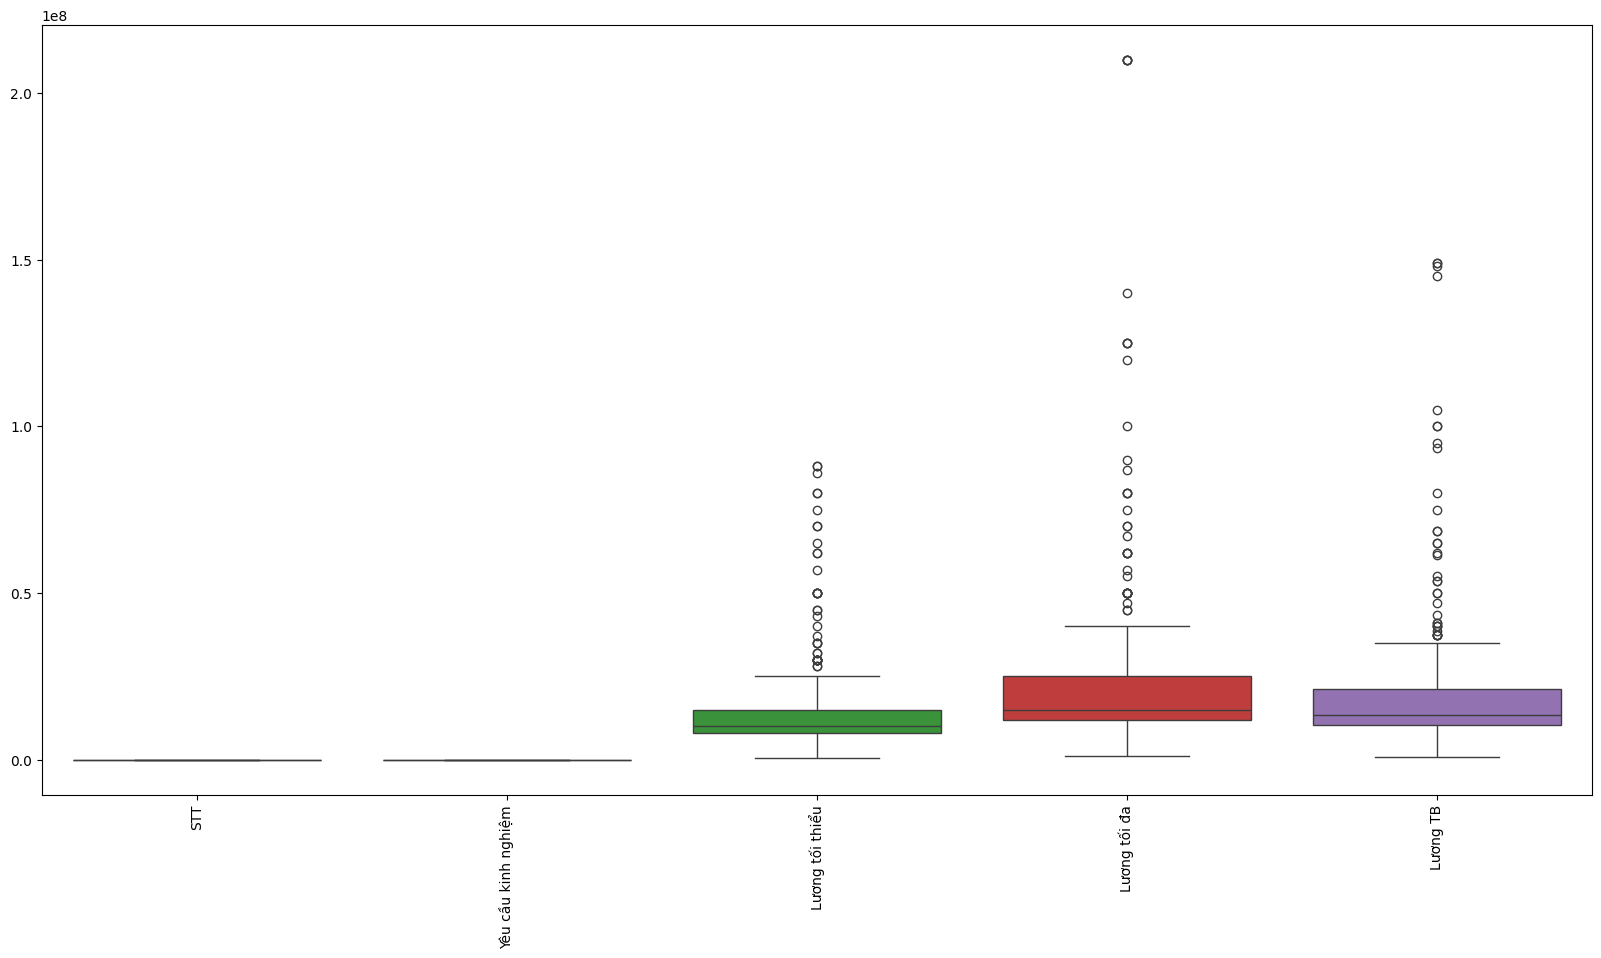

In [226]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=df_filtered[numerical])
plt.xticks(rotation=90)
plt.show()

In [227]:
Q1 = df_filtered['Lương TB'].quantile(0.25)
Q3 = df_filtered['Lương TB'].quantile(0.75)
IQR = Q3 - Q1
df_filtered = df_filtered[(df_filtered['Lương TB'] >= Q1 - 1.5*IQR) & (df_filtered['Lương TB'] <= Q3 + 1.5*IQR)]
df_filtered.shape

(389, 12)

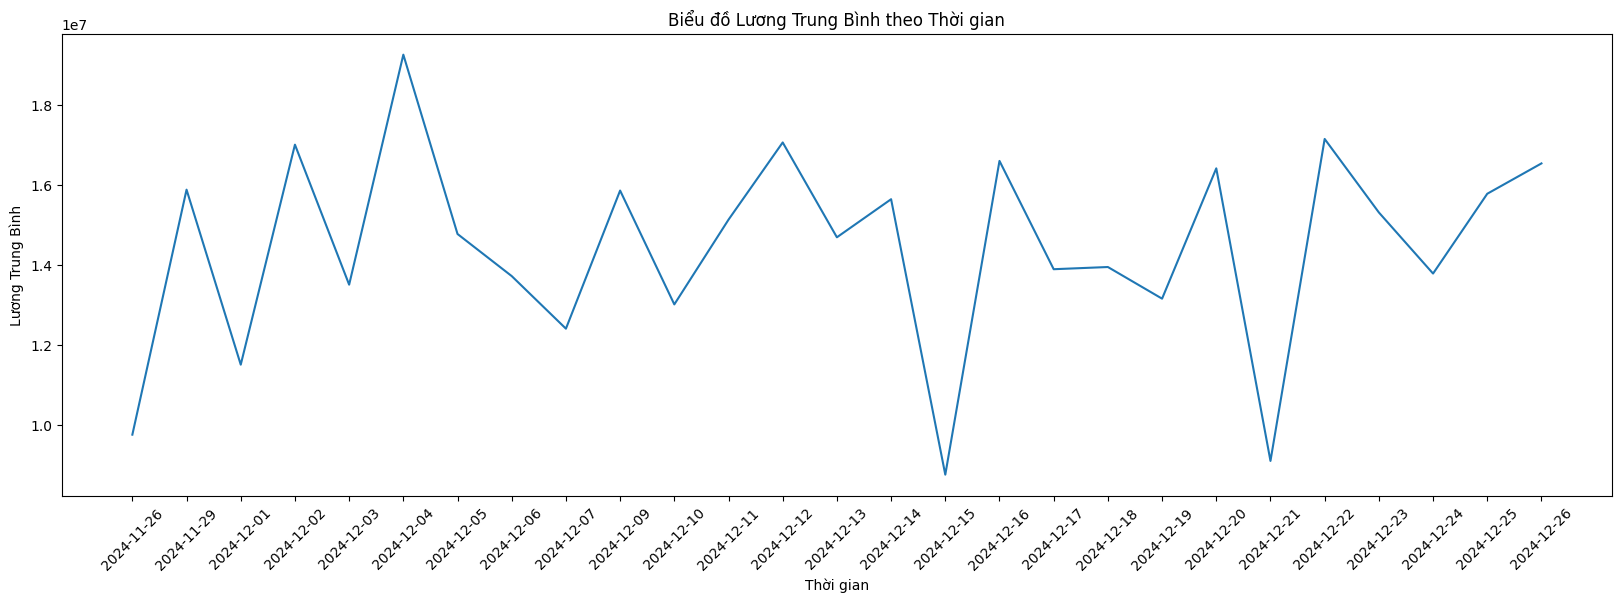

In [228]:
# Tạo cột 'Lương TB'
df_filtered['Lương TB'] = df_filtered.groupby('Ngày đăng tuyển')['Lương TB'].transform('mean')

# Sắp xếp df_filtered theo 'Ngày đăng tuyển' tăng dần
df_filtered = df_filtered.sort_values(by='Ngày đăng tuyển')

# Vẽ biểu đồ line
plt.figure(figsize=(20, 6))
sns.lineplot(x='Ngày đăng tuyển', y='Lương TB', data=df_filtered, errorbar=None)

# Thiết lập tiêu đề và nhãn trục
plt.title('Biểu đồ Lương Trung Bình theo Thời gian')
plt.xlabel('Thời gian')
plt.ylabel('Lương Trung Bình')
plt.xticks(rotation=45)

# Hiển thị biểu đồ
plt.show()

Qua biểu đồ nhận thấy được mức lương không bị ảnh hưởng bởi thời gian

Xét độ tương quan giữa Địa điểm và Lương Trung Bình

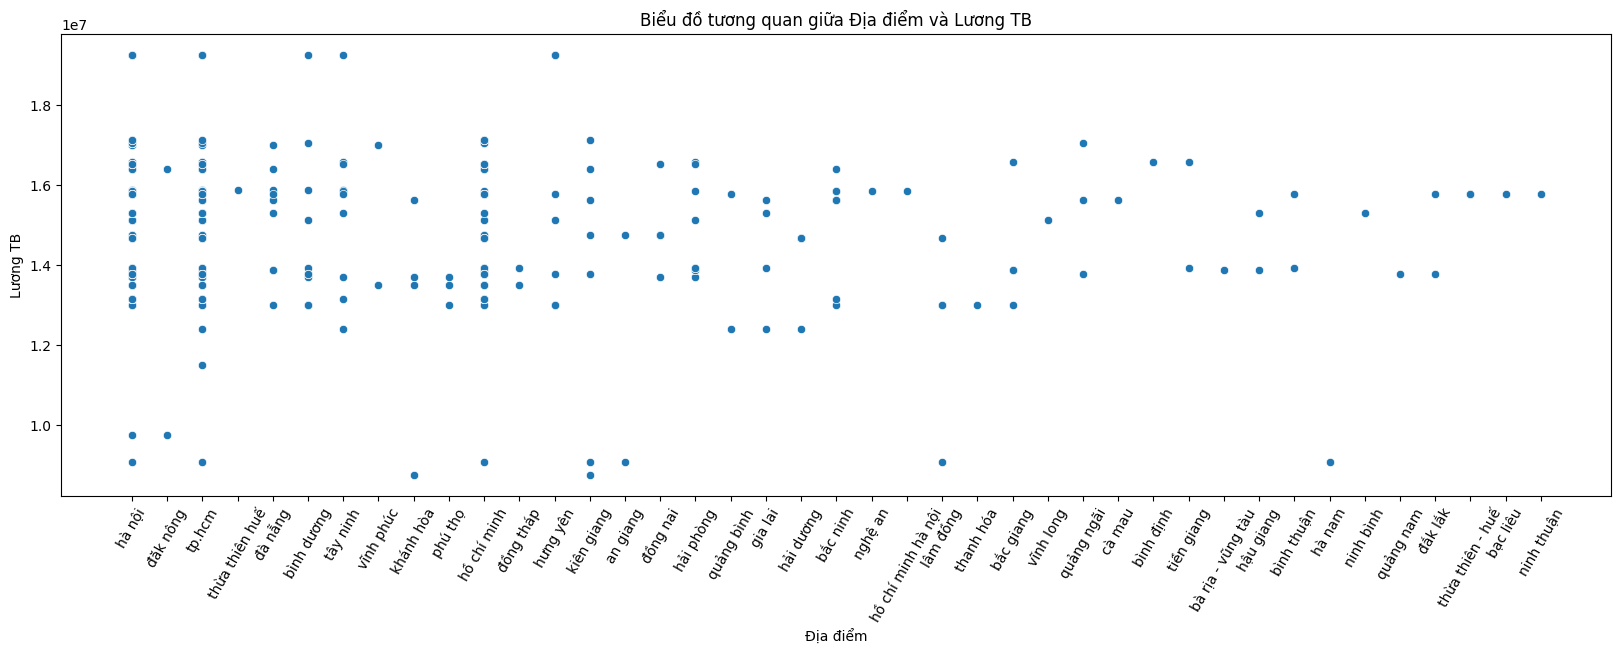

In [229]:
# Vẽ biểu đồ scatter plot với seaborn
plt.figure(figsize=(20, 6))
sns.scatterplot(x='Địa điểm', y='Lương TB', data=df_filtered)
plt.title('Biểu đồ tương quan giữa Địa điểm và Lương TB')
plt.xticks(rotation=60)
plt.show()

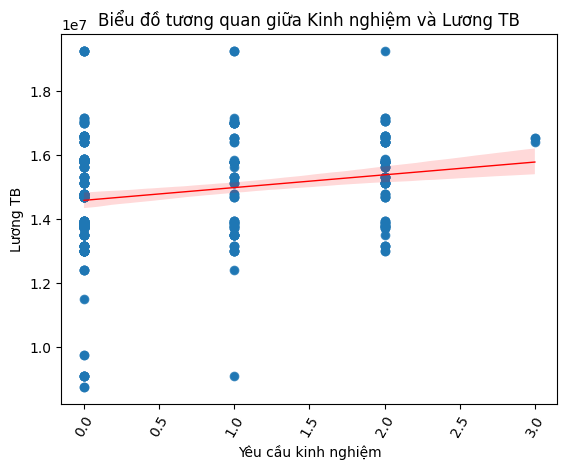

In [230]:
# Vẽ biểu đồ scatter plot với seaborn
sns.scatterplot(x='Yêu cầu kinh nghiệm', y='Lương TB', data=df_filtered)
sns.regplot(x='Yêu cầu kinh nghiệm', y='Lương TB', data=df_filtered,
            line_kws={'color':'red', 'linewidth': 1})
plt.title('Biểu đồ tương quan giữa Kinh nghiệm và Lương TB')
plt.xticks(rotation=60)
plt.show()

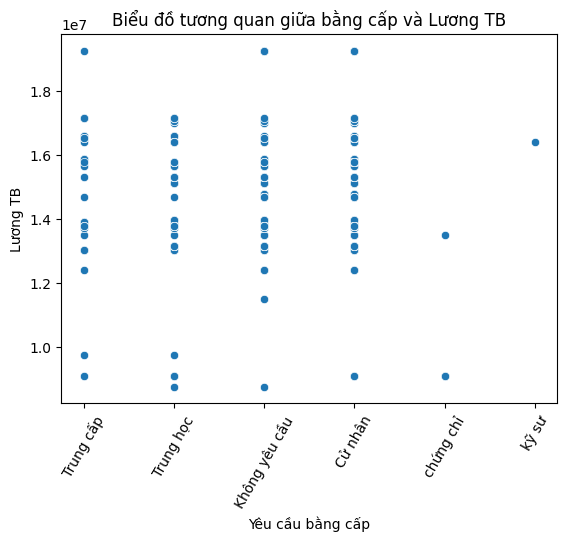

In [231]:
sns.scatterplot(x='Yêu cầu bằng cấp', y='Lương TB', data=df_filtered)
plt.title('Biểu đồ tương quan giữa bằng cấp và Lương TB')
plt.xticks(rotation=60)
plt.show()

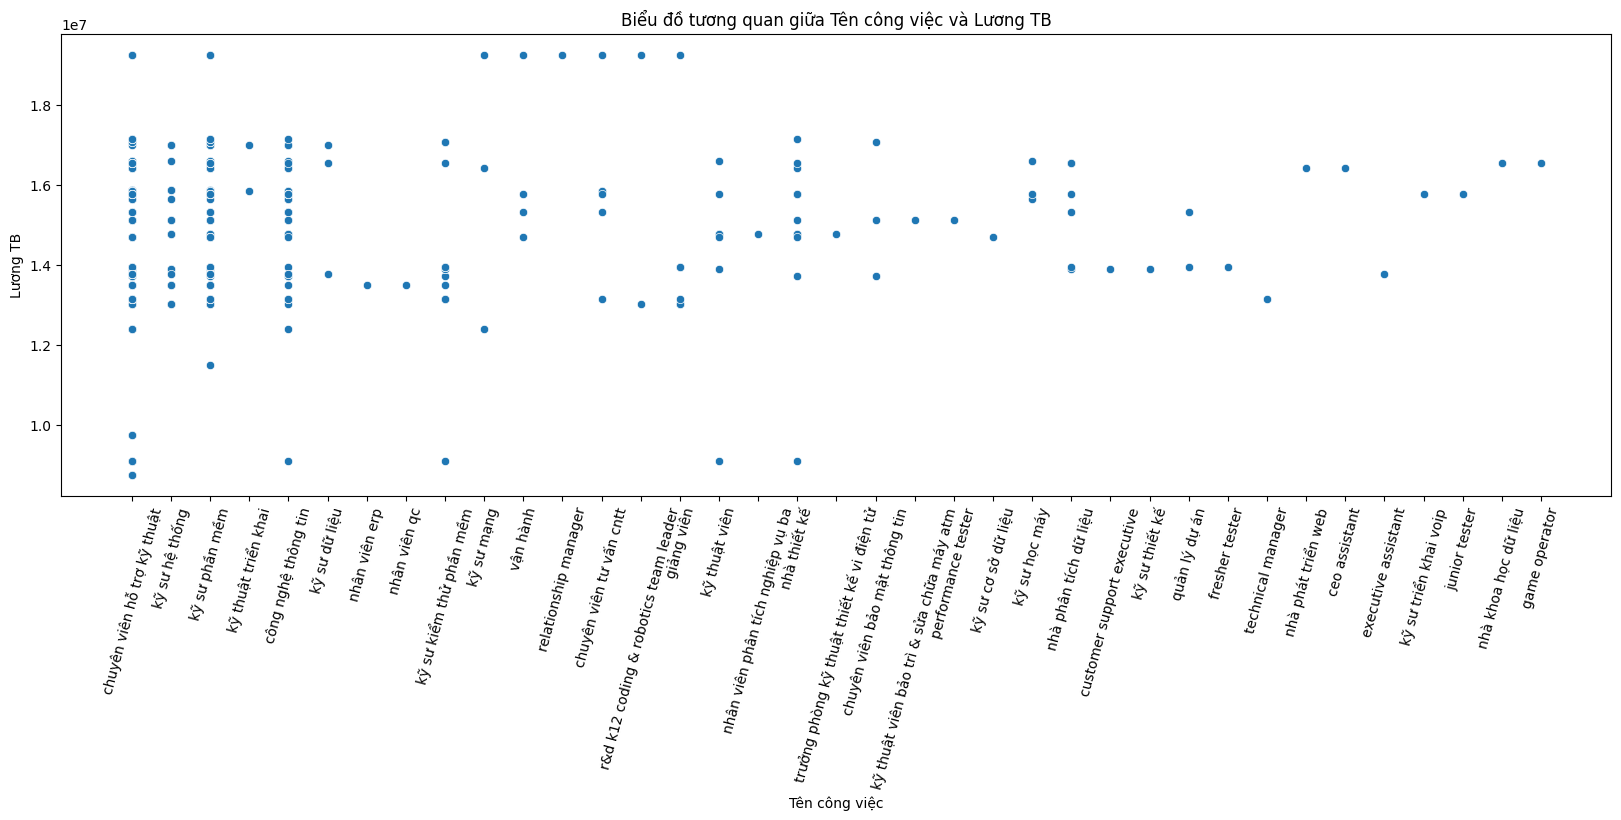

In [232]:
plt.figure(figsize=(20, 6))
sns.scatterplot(x='Tên công việc', y='Lương TB', data=df_filtered)
plt.title('Biểu đồ tương quan giữa Tên công việc và Lương TB')
plt.xticks(rotation=75)
plt.show()

Dễ nhận thấy mức lương trung bình tăng dần theo kinh nghiệm làm việc

Địa điểm cũng không mang lại cái nhìn trực quan

In [233]:
# Tính median theo tổ hợp nhóm các yếu tố
median_by_groups = df_filtered.groupby(
    ['Vị trí ứng tuyển', 'Yêu cầu bằng cấp', 'Yêu cầu kinh nghiệm', 'Địa điểm']
)['Lương tối thiểu'].median().reset_index()

# Chuyển đổi thành từ điển để ánh xạ nhanh
group_median_dict = median_by_groups.set_index(
    ['Vị trí ứng tuyển', 'Yêu cầu bằng cấp', 'Yêu cầu kinh nghiệm', 'Địa điểm']
)['Lương tối thiểu'].to_dict()

# Hàm điền giá trị lương tối thiểu
def group_based_imputation(row):
    if pd.notna(row['Lương tối thiểu']) and row['Lương tối thiểu'] > 0:
        return row['Lương tối thiểu']  # Giữ nguyên nếu lương tối thiểu đã hợp lệ

    # Ánh xạ tổ hợp các yếu tố để điền lương tối thiểu
    key = (row['Vị trí ứng tuyển'], row['Yêu cầu bằng cấp'], row['Yêu cầu kinh nghiệm'], row['Địa điểm'])
    if key in group_median_dict:
        return group_median_dict[key]

    # Nếu không có trong nhóm, điền bằng median toàn cục
    return df_filtered['Lương tối thiểu'].median()

# Áp dụng hàm
df_cleaned['Lương tối thiểu'] = df_cleaned.apply(group_based_imputation, axis=1)

# Kiểm tra số lượng lương còn thiếu
print("Số lượng giá trị lương còn thiếu:", df_cleaned['Lương tối thiểu'].isna().sum())

Số lượng giá trị lương còn thiếu: 0


In [234]:
# Tính median theo tổ hợp nhóm các yếu tố
median_by_groups = df_filtered.groupby(
    ['Vị trí ứng tuyển', 'Yêu cầu bằng cấp', 'Yêu cầu kinh nghiệm', 'Địa điểm']
)['Lương tối đa'].median().reset_index()

# Chuyển đổi thành từ điển để ánh xạ nhanh
group_median_dict = median_by_groups.set_index(
    ['Vị trí ứng tuyển', 'Yêu cầu bằng cấp', 'Yêu cầu kinh nghiệm', 'Địa điểm']
)['Lương tối đa'].to_dict()

# Hàm điền giá trị lương tối đa
def group_based_imputation(row):
    if pd.notna(row['Lương tối đa']) and row['Lương tối đa'] > 0:
        return row['Lương tối đa']  # Giữ nguyên nếu lương tối đa đã hợp lệ

    # Ánh xạ tổ hợp các yếu tố để điền lương tối đa
    key = (row['Vị trí ứng tuyển'], row['Yêu cầu bằng cấp'], row['Yêu cầu kinh nghiệm'], row['Địa điểm'])
    if key in group_median_dict:
        return group_median_dict[key]

    # Nếu không có trong nhóm, điền bằng median toàn cục
    return df_filtered['Lương tối đa'].median()

# Áp dụng hàm
df_cleaned['Lương tối đa'] = df_cleaned.apply(group_based_imputation, axis=1)

# Kiểm tra số lượng lương còn thiếu
print("Số lượng giá trị lương còn thiếu:", df_cleaned['Lương tối đa'].isna().sum())

Số lượng giá trị lương còn thiếu: 0


In [235]:
df_cleaned.head()

,STT,Trang thu thập,Tên công ty,Vị trí ứng tuyển,Yêu cầu bằng cấp,Yêu cầu kinh nghiệm,Địa điểm,Ngày đăng tuyển,Lương tối thiểu,Lương tối đa,Lương TB,Tên công việc
0,0,CareerLink,CÔNG TY CỔ PHẦN KINH DOANH F88,Nhân viên,Cử nhân,2,hà nội,2024-12-26,15000000.0,25000000.0,20000000.0,kỹ sư dữ liệu
1,1,CareerLink,CÔNG TY TNHH NITTO DENKO VIỆT NAM,Nhân viên,Cử nhân,0,bình dương,2024-12-26,10000000.0,15000000.0,0.0,chuyên viên hỗ trợ kỹ thuật
2,2,CareerLink,CÔNG TY CỔ PHẦN KINH DOANH F88,Nhân viên,Cử nhân,3,hà nội,2024-12-26,15000000.0,25000000.0,20000000.0,nhà khoa học dữ liệu
3,3,CareerLink,CÔNG TY TNHH SEOJIN AUTO,Nhân viên,Cử nhân,1,bắc ninh,2024-12-26,10000000.0,15000000.0,0.0,chuyên viên bảo mật thông tin
4,4,CareerLink,CÔNG TY CỔ PHẦN KINH DOANH F88,Nhân viên,Cử nhân,3,hà nội,2024-12-26,20000000.0,35000000.0,27500000.0,nhà phân tích dữ liệu


Xử lý dữ liệu ngoại lai

In [236]:
df_cleaned['Lương TB'] = (df_cleaned['Lương tối thiểu'] + df_cleaned['Lương tối đa']) / 2

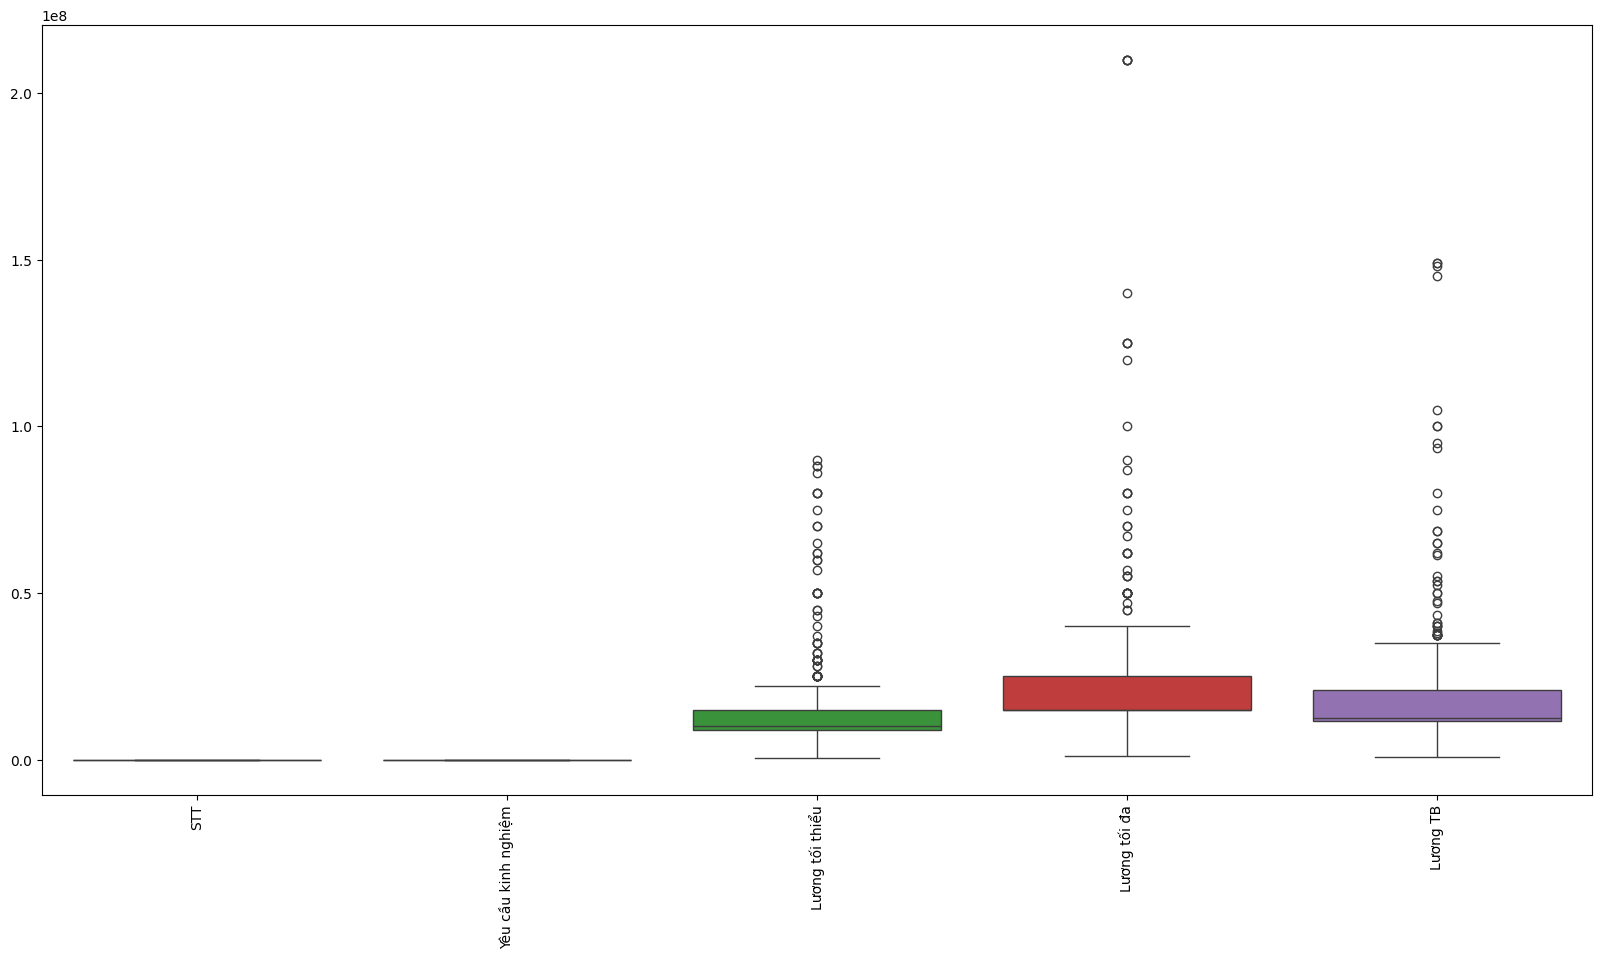

In [237]:
numerical = df_cleaned.select_dtypes(include=[np.number]).columns
categorical = df_cleaned.select_dtypes(include=[object]).columns 

plt.figure(figsize=(20, 10))
sns.boxplot(data=df_cleaned[numerical])
plt.xticks(rotation=90)
plt.show()

In [238]:
Q1 = df_cleaned['Lương TB'].quantile(0.25)
Q3 = df_cleaned['Lương TB'].quantile(0.75)
IQR = Q3 - Q1
df_cleaned = df_cleaned[(df_cleaned['Lương TB'] >= Q1 - 1.5*IQR) & (df_cleaned['Lương TB'] <= Q3 + 1.5*IQR)]
df_cleaned.shape

(677, 12)

# Các câu hỏi liên quan

Mức lương tuyển dụng trong ngành công nghệ thông tin phần lớn là bao nhiêu?

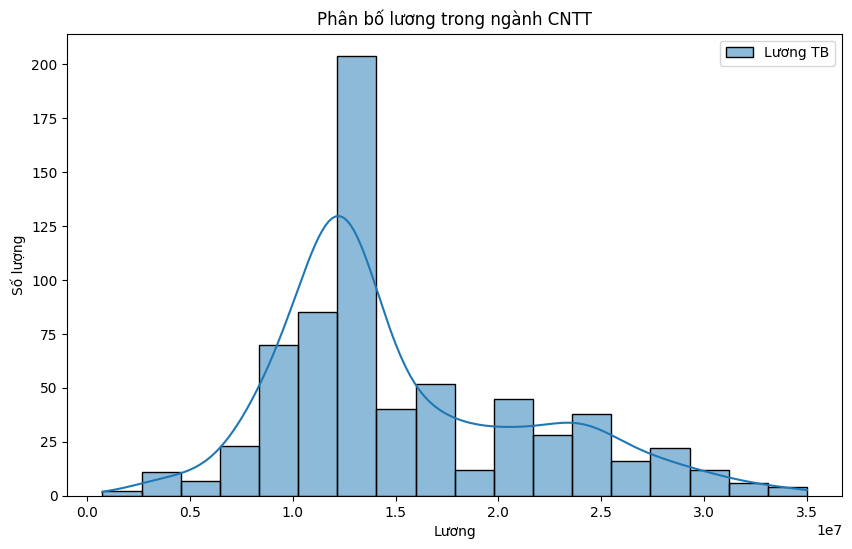

In [239]:
plt.figure(figsize=(10, 6))
# sns.histplot(df['Lương tối thiểu'], kde=True, label='Lương tối thiểu')
sns.histplot(df_cleaned['Lương TB'], kde=True, label='Lương TB')
plt.title('Phân bố lương trong ngành CNTT')
plt.xlabel('Lương')
plt.ylabel('Số lượng')
plt.legend()
plt.show()

Nhận xét: mức lương được tuyển dụng trong tầm khoảng 3tr VND cho tới 35tr VND và đạt mức tuyển dụng nhiều nhất ở mức lương 12tr VND 

Công việc nào được ứng tuyển nhiều nhất?

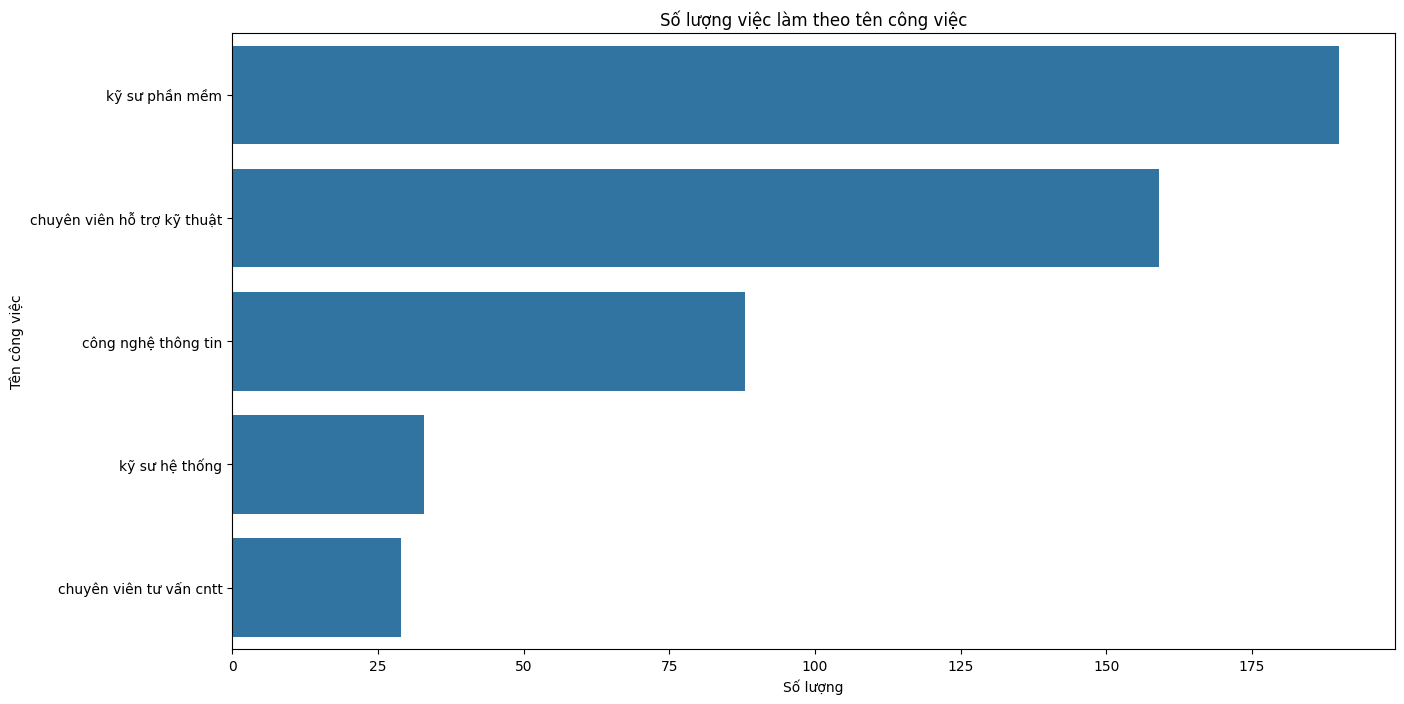

In [240]:
plt.figure(figsize=(15, 8))
sns.countplot(y='Tên công việc', data=df_cleaned, order=df_cleaned['Tên công việc'].value_counts().index[:5])
plt.title('Số lượng việc làm theo tên công việc')
plt.xlabel('Số lượng')
plt.ylabel('Tên công việc')
plt.show()

Kỹ sư phần mềm được các nhà tuyển dụng săn đón nhiều nhất

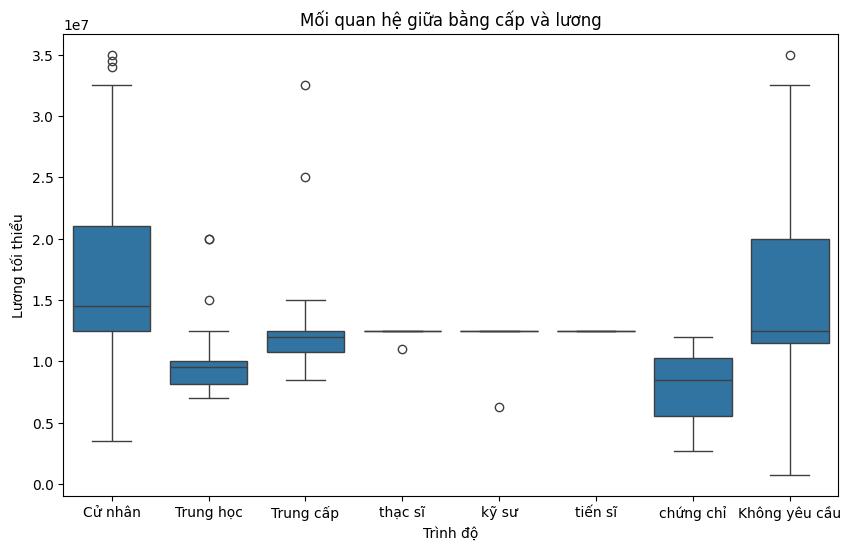

In [241]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Yêu cầu bằng cấp', y='Lương TB', data=df_cleaned) 
plt.title('Mối quan hệ giữa bằng cấp và lương')
plt.xlabel('Trình độ')
plt.ylabel('Lương tối thiểu')
plt.show()

Nhìn vào biểu đồ nhận thấy được các nhà tuyển dụng thường tuyển cử nhân hoặc là không yêu cầu bằng cấp và không có độ chênh lệch nhiều về mức lương

Trong 3 tháng gần đây ngành nghề nào được tuyển dụng nhiều nhất?

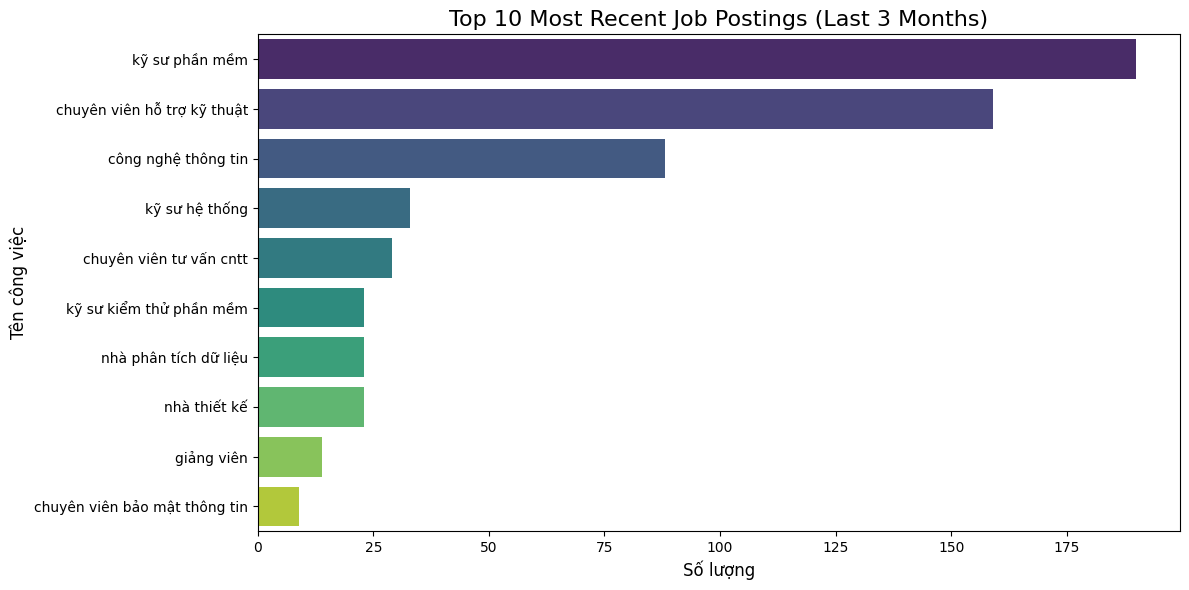

In [242]:
from datetime import datetime, timedelta
# Chuyển đổi cột `Ngày đăng tuyển` sang kiểu dữ liệu datetime
df_cleaned['Ngày đăng tuyển'] = pd.to_datetime(df_cleaned['Ngày đăng tuyển'])

# Lọc dữ liệu trong vòng 3 tháng gần đây
today = datetime.today()
three_months_ago = today - timedelta(days=90)
recent_job_postings = df_cleaned[df_cleaned['Ngày đăng tuyển'] >= three_months_ago]

# Nhóm dữ liệu theo `Tên công việc` và đếm số lượng công việc
top_recent_jobs = (recent_job_postings.groupby('Tên công việc')['Tên công việc']
                   .count()
                   .sort_values(ascending=False))

# Lấy 10 công việc hàng đầu
top_10_recent_jobs = top_recent_jobs.head(10)

# Tạo DataFrame từ Series `top_10_recent_jobs`
top_10_recent_jobs_df = top_10_recent_jobs.reset_index(name='Số lượng')

# Vẽ biểu đồ bar với `Tên công việc` trên trục x và `Số lượng` trên trục y
plt.figure(figsize=(12, 6))
sns.barplot(x='Số lượng', y='Tên công việc', data=top_10_recent_jobs_df, hue='Tên công việc', palette='viridis', legend=False)
plt.title('Top 10 Most Recent Job Postings (Last 3 Months)', fontsize=16)
plt.xlabel('Số lượng', fontsize=12)
plt.ylabel('Tên công việc', fontsize=12)
plt.tight_layout()


plt.show()

Công việc được tuyển dụng nhiều nhất tại thành phồ hồ chí minh và mức lương bao nhiêu?

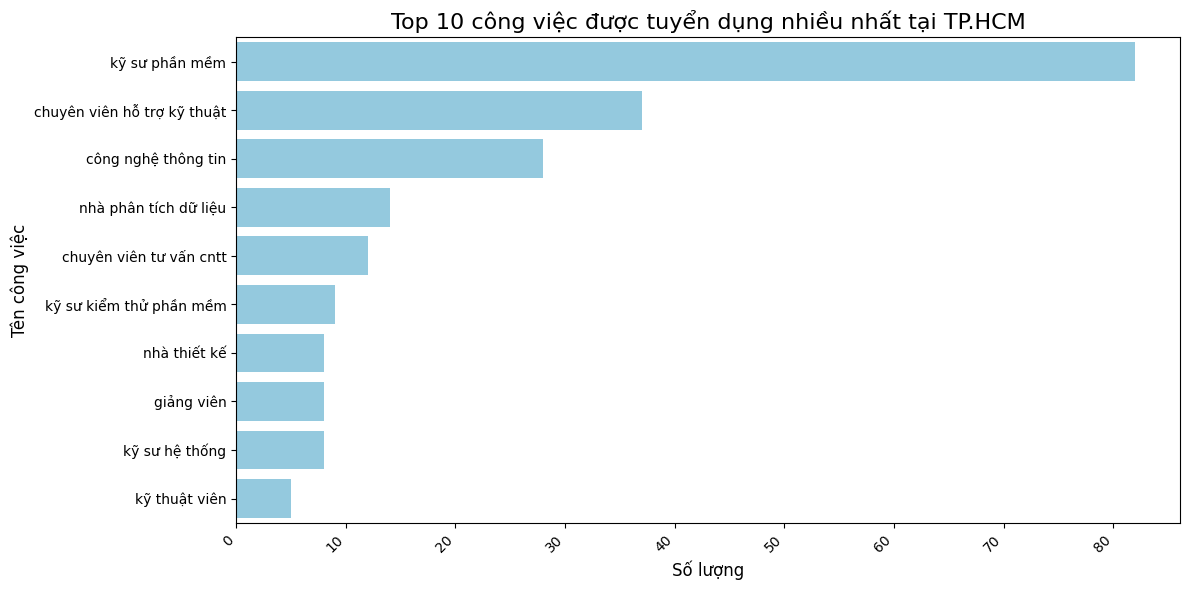

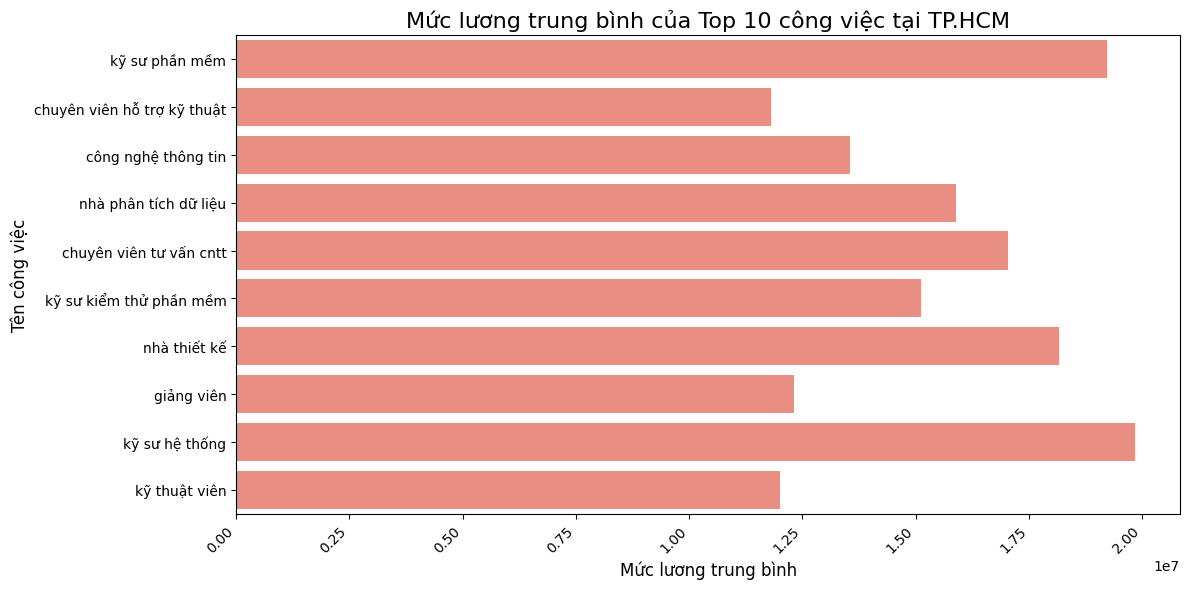

In [243]:
# Phân tích công việc được tuyển dụng nhiều nhất tại TP.HCM và Hồ Chí Minh
hcm_jobs = df_cleaned[df_cleaned['Địa điểm'].str.contains('tp.hcm|hồ chí minh', case=False, na=False)]
job_salary_analysis = hcm_jobs.groupby('Tên công việc').agg(
    So_luong=('Tên công việc', 'count'),
    Luong_trung_binh=('Lương TB', 'mean')
).sort_values(by='So_luong', ascending=False)

# Lấy 10 công việc hàng đầu
top_10_jobs = job_salary_analysis.head(10)

# Vẽ biểu đồ số lượng công việc
plt.figure(figsize=(12, 6))
sns.barplot(x='So_luong', y=top_10_jobs.index, data=top_10_jobs, color='skyblue')  # Sử dụng color để tránh cảnh báo
plt.title('Top 10 công việc được tuyển dụng nhiều nhất tại TP.HCM', fontsize=16)
plt.xlabel('Số lượng', fontsize=12)
plt.ylabel('Tên công việc', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('job_analysis_hcm.png')

# Vẽ biểu đồ mức lương trung bình
plt.figure(figsize=(12, 6))
sns.barplot(x='Luong_trung_binh', y=top_10_jobs.index, data=top_10_jobs, color='salmon')
plt.title('Mức lương trung bình của Top 10 công việc tại TP.HCM', fontsize=16)
plt.xlabel('Mức lương trung bình', fontsize=12)
plt.ylabel('Tên công việc', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('salary_analysis_hcm.png')

plt.show()